In [1]:
!pip install seaborn

Looking in indexes: http://192.168.2.228:8888/repository/pypi/simple
DEPRECATION: moxing-framework 2.1.16.2ae09d45 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of moxing-framework or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [9]:
# 步骤一：导入相关库
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import zipfile

In [10]:
# 步骤二：加载数据集
# 选用：以下为解压airplane.zip数据集代码
# zipfile_path = './airplane.zip'  # 压缩文件的路径
# output_path = './'  # 解压后的输出目录
# with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
#    zip_ref.extractall(output_path)
# 2.1 设置数据路径和图像尺寸
data_dir = "airplane"
image_size = (64, 64)
os.makedirs('./output', exist_ok=True)

# 2.2 定义读取图像文件夹的函数
def load_image_folder(path):
    X = []
    y = []
    class_names = sorted(os.listdir(path))
    for label, cls in enumerate(class_names):
        cls_path = os.path.join(path, cls)
        for fname in os.listdir(cls_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(cls_path, fname)
                # 请在此处编写代码：读取图像，转换RGB，resize，归一化，展平
                img = Image.open(img_path).convert('RGB')
                img = img.resize(image_size)
                img_array = np.array(img) / 255.0
                img_array = img_array.transpose(2, 0, 1).flatten()
                X.append(img_array)
                y.append(label)
    return np.array(X), np.array(y), class_names

# 2.3 加载训练集和测试集
# 请在此处编写代码：调用load_image_folder加载train和test数据
X_train, y_train, classes = load_image_folder(os.path.join(data_dir, 'train'))
X_test, y_test, _ = load_image_folder(os.path.join(data_dir, 'test'))

# 2.4 对训练集和测试集进行标准化处理
scaler = StandardScaler()
# 请在此处编写代码：使用StandardScaler进行归一化处理
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# 步骤三：逻辑回归模型的构建
# 3.1 使用sklearn库中的LogisticRegression构建多分类逻辑回归模型
# 请在此处编写代码：构造LogisticRegression模型，设置合适参数
clf = LogisticRegression(
    multi_class='multinomial', # 指定多分类方法（softmax回归）
    solver='lbfgs', # 支持多分类的优化算法
    C=1.0, # 正则化强度的倒数
    max_iter=1000, # 增加迭代次数确保收敛
    random_state=42 # 随机种子保证可复现性
)

In [12]:
# 步骤四：训练模型
# 4.1 使用训练数据拟合逻辑回归模型
# 请在此处编写代码：训练clf模型
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

In [13]:
# 步骤五：模型评估
# 5.1 使用训练好的模型对测试数据进行预测
# 请在此处编写代码：使用clf进行预测
y_pred = clf.predict(X_test)

# 5.2 计算测试集上的准确率
# 请在此处编写代码：计算accuracy并打印
acc = accuracy_score(y_test, y_pred)
print('********On Test Data********')
print(f"Accuracy: {acc:.4f}")

# 5.3 计算混淆矩阵
# 请在此处编写代码：计算confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)

********On Test Data********
Accuracy: 0.7100


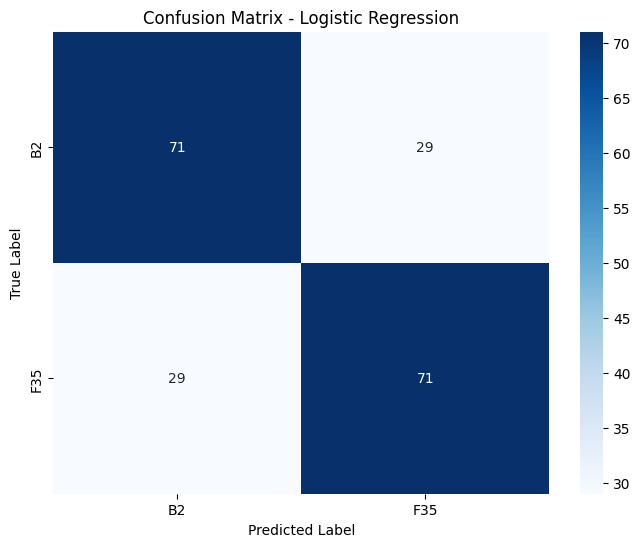

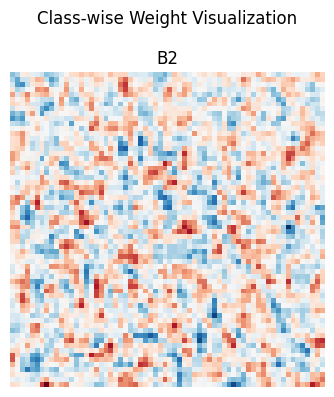

In [14]:
# 步骤六：结果保存与可视化
# 6.1 绘制并保存混淆矩阵热力图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.savefig('./output/sklearn_logreg_confusion_matrix.png')
plt.show()

# 6.2 可视化并保存模型权重
def visualize_weights(model, shape=(32, 32), class_names=None):
    coef = model.coef_
    num_classes = coef.shape[0]
    num_channels = 3

    fig, axes = plt.subplots(1, num_classes, figsize=(4*num_classes, 4))
    if num_classes == 1:
        axes = [axes]

    for i in range(num_classes):
        ax = axes[i]
        weight = coef[i].reshape(num_channels, *shape)
        weight_img = weight.mean(axis=0)
        ax.imshow(weight_img, cmap='RdBu', interpolation='nearest')
        ax.axis('off')
        ax.set_title(class_names[i] if class_names else f"Class {i}")

    plt.suptitle("Class-wise Weight Visualization")
    plt.tight_layout()
    plt.savefig('./output/logreg_weight_visualization.png')
    plt.show()

# 6.3 调用权重可视化函数
visualize_weights(clf, shape=image_size, class_names=classes)

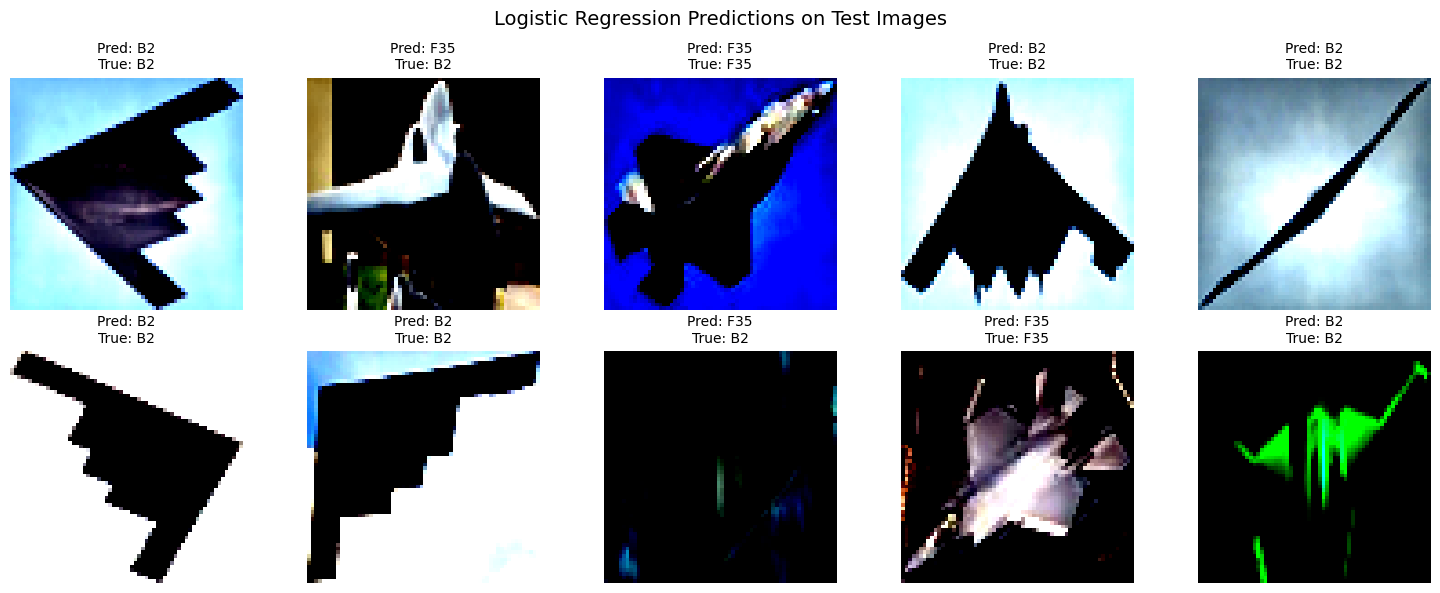

In [15]:
# 步骤七：推理结果可视化（展示若干张测试图像及预测结果）
def visualize_predictions(X_test_raw, y_true, y_pred, class_names, shape=(64, 64), num_images=10):
    """
    随机选择若干张测试图像，显示其预测结果与真实标签
    """
    indices = np.random.choice(len(X_test_raw), size=num_images, replace=False)  # 请在此处编写代码：随机选择num_images个样本索引
    plt.figure(figsize=(15, 6))

    for i, idx in enumerate(indices):
        img_array = X_test_raw[idx]
        true_label = y_true[idx]  # 请在此处编写代码：获取真实标签
        pred_label = y_pred[idx]  # 请在此处编写代码：获取预测标签

        # 还原图像：一维向量 -> (3, H, W) -> (H, W, 3)
        img = img_array.reshape(3, *shape).transpose(1, 2, 0)  # 请在此处编写代码：reshape并transpose为可显示图像格式
        img = np.clip(img, 0, 1)  # 请在此处编写代码：限制像素值在0-1范围（使用np.clip）

        plt.subplot(2, (num_images + 1) // 2, i + 1)
        plt.imshow(img)
        plt.title(f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}", fontsize=10)
        plt.axis('off')

    plt.suptitle("Logistic Regression Predictions on Test Images", fontsize=14)
    plt.tight_layout()
    plt.savefig('./output/logreg_test_predictions.png')
    plt.show()

# 步骤七调用：推理可视化函数
visualize_predictions(X_test, y_test, y_pred, classes, shape=image_size, num_images=10)